# xarray

xarray is
- a multi-dimensional version of pandas
- built for working with netcdf files
- can use dask to automatically parallelise operations on your data and work with larger than memory datasets.

xarray has quickly found support in the climate community and forms the basis of a [major new project called Pangeo](http://blogs.ei.columbia.edu/2017/09/13/pangeo-project-will-improve-access-to-climate-data/) that aims to be a toolkit for effective analysis of climate model datasets.  There is more on Pangeo and how you can get involved at the end of this tutorial.

The equivalent of a pandas dataframe is an xarray **```dataset```**.  A dataset has:
- data variables e.g. an array of temperature data
- Coordinates that index the axes of the data variables
- dimension names for each axis.

The schematic shows how this would look where ```temperature``` and ```precipitation``` are data variables, ```lat``` and ```lon``` are 2D corrdinates while ```x```, ```y```, ```z``` and ```time``` are the dimension names.

[![a](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)

Just as in pandas, the label names for the dimensions mean that we can use these labels directly when writing our analysis code.

Even better, using labels means that we don't have to remember the order of the dimensions in the underlying array. 

## Reading netcdf files
xarray is built to work with netcdf files.  This means that when xarray reads a netcdf file, it takes into account the metadata for each variable that show the variable name.

In this workshop we will work with a sub-sample of the output from the ORCA global numerical model run at 1/12 th degree resolution.  The sample we use comes from the Nordic Seas off the coast of Norway.  There are two files, each 9 Mb in size.  

Firstly, we work with the output of SST and SSS (salinity) for 1990. We use xarray's ```.open_dataset()``` function to read the files.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

ds = xr.open_dataset('nordic_seas_1990.nc')
ds

<xarray.Dataset>
Dimensions:  (t: 12, x: 175, y: 250)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * y        (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x        (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t        (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst      (t, y, x) float64 ...
    sss      (t, y, x) float64 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:                   39
    conventions:          CF-1.1
    production:           An IPSL model
    jbegin:               1
    DOMAIN_number_total:  80
    history:              Tue Mar 14 09:12:45 2017: /usr/bin/ncatted -a _Fill...
    description:          ocean T grid variables

The ```.open_dataset``` method is always **lazy**.  This means that the data has not been read from the file, xarray has just 
- opened the file and
- gathered the metadata
- and created the dataset object ```ds```

Getting data from a file on disk is a bit like drinking from a bottle of coke.  You can't just turn the bottle over to start pouring.  Instead, you have to take the lid off the bottle to open it, then you can pour it. Once you're done pouring it you should put the lid back on.

With ```.open_dataset``` you are taking the lid off the bottle, but not pouring from it until you're ready to drink.

### Inspecting the dataset ```ds```

The dimensions of this dataset  are ```t```, ```x``` and ```y```.  

The coordinates of this dataset are ```t```, ```x``` and ```y``` plus ```lon``` and ```lat```.

The ```x``` and ```y``` coordinates are the indices of the Nordic Seas in the global grid.  The ```t``` coordinate is a datetime series.  The ```lon``` and ```lat``` coordinates and the 2D coordinates in *physical* space.

The data variables are the sea surface temperature ```sst``` and the sea surface salinity ```sss```.  Both ```sst``` and ```sss``` have dimensions ```t```,```y```, and ```x```.  There is then a set of attributes about the overall model run that are not used for computation.

## Labelled data
The variables and each of their dimensions now have labels attached.  This is great news!  

The first advantage of labelled data is that we can use these labels when analysing the outputs without needing to figure out which dimension is which.

For example, let's take the time-mean of the SST field and plot it:

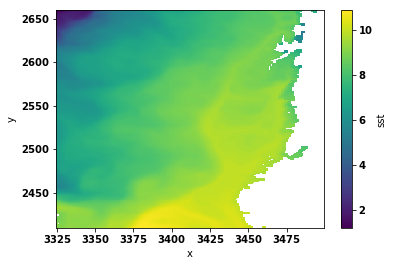

In [3]:
ds.sst.mean(dim = 't').plot()

Imagine coming back to this code months after you've written it - you'll know immediately what it does.

As the array becomes two dimensional when the time-mean is taken, xarray plots the field as a 2d color plot.  It also adds a colorbar and axis labels.  Unfortunately, it uses the model coordinates rather than the physical coordinates as a default.  [This page](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html) shows how to plot with the physical coordinates and a projection.

We can also take more control over the plot by passing the ax object to the ```.plot()``` method.

/home/lbran/anaconda2/envs/base3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


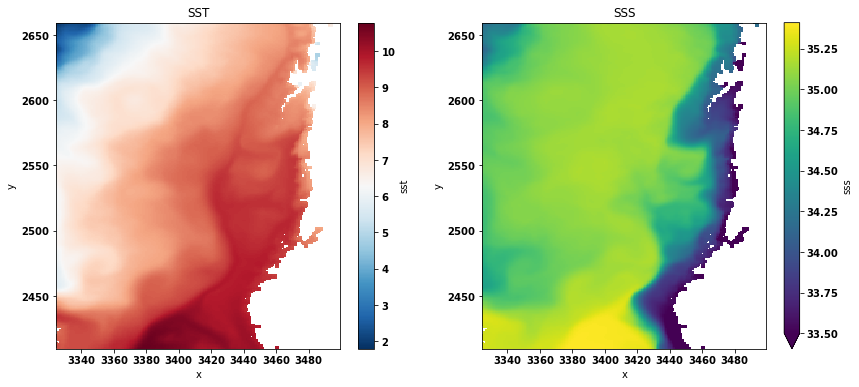

In [24]:
# Create two subplots side-by-side
fig, ax = plt.subplots(1, 2, figsize = (14,6))
# Plot SST in the first subplot with a Red-Blue colormap
ds.sst.mean(dim = 't').plot(ax = ax[0], cmap = plt.cm.RdBu_r)
# Plot SSS in the second subplot with the default colormap and a minimum value for the colormap limits
ds.sss.mean(dim = 't').plot(ax = ax[1], vmin = 33.5)
# Add a title to the first subplot
ax[0].set_title('SST')
# Add a title to the second subplot
ax[1].set_title('SSS')

In the left-hand plot we can see the ribbon of warm water flowing north as part of the Norwegian Slope Current. On the right we can see that the water closest to the Norwegian coast is generally fresher due to freshwater input from the land.  

We can take mean in multiple directions simultaneously by passing the dimension names as a list.

In the example below we plot the time and zonal mean of the SST and plot against latitude.

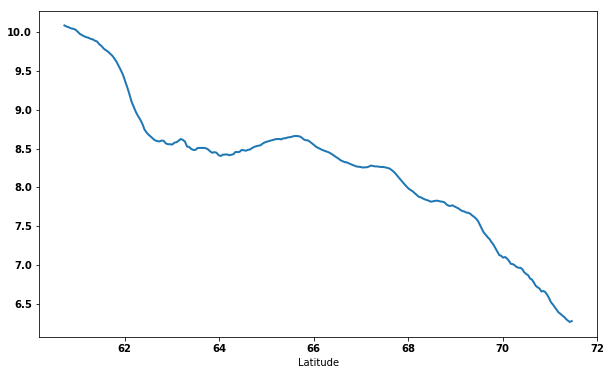

In [4]:
# Create the figure and axis objects
fig, ax = plt.subplots( figsize = (10,6))
# Plot the latitude against the SST
ax.plot(ds.lat.mean(dim = 'x'), ds.sst.mean(dim = ['t','x']));
ax.set_xlabel('Latitude')

## Operations on labelled data

The second advantage of labelled data is that xarray keeps track of the dimensions when we perform operations on the variables.  For example, we can create a new variable in the dataset ```ds``` that holds the time-mean SST.

To add a new column you must use the square brackets notation on the left-hand side and not the dot notation.

In [6]:
ds['sst_mean'] = ds.sst.mean(dim = 't')
ds

<xarray.Dataset>
Dimensions:   (t: 12, x: 175, y: 250)
Coordinates:
    lon       (y, x) float64 ...
    lat       (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y         (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x         (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t         (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst       (t, y, x) float64 nan 7.726 7.71 7.684 7.729 7.848 7.982 8.148 ...
    sss       (t, y, x) float64 ...
    sst_mean  (y, x) float64 nan 9.087 9.084 9.078 9.109 9.16 9.189 9.208 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:                   39
    conventions:          CF-1.1
    production:           An IPSL model
    jbegin:               1

Xarray has seen that you've taken the time-mean and reduced the dimension of ```sst_mean``` accordingly to just ```y``` and ```x```.  This means that you don't have to worry about singleton dimensions hanging around.

Even better, xarray will take care of the details when you do operations between variables with dimensions that aren't identical

In [7]:
ds['sst_anomalies'] = ds.sst - ds.sst_mean
ds

<xarray.Dataset>
Dimensions:        (t: 12, x: 175, y: 250)
Coordinates:
    lon            (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 ...
    lat            (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 ...
  * y              (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 ...
  * x              (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 ...
  * t              (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst            (t, y, x) float64 nan 7.726 7.71 7.684 7.729 7.848 7.982 ...
    sss            (t, y, x) float64 ...
    sst_mean       (y, x) float64 nan 9.087 9.084 9.078 9.109 9.16 9.189 ...
    sst_anomalies  (t, y, x) float64 nan -1.361 -1.373 -1.395 -1.38 -1.312 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                 

So in this case xarray handled the broadcasting needed to add the ```t``` dimension back on to the ```sst_mean``` variable.

## Indexing data

Indexing in xarray follows concepts from pandas. In pandas you use ```.loc``` to select data using the explicit index and ```.iloc``` to select data using the *implicit* index (i.e. an integer count of the rows).

In xarray you use **```.sel```** to select data using the **explicit** coordinate index and **```.isel```** to select data using the *implicit* coordinate index (i.e. an integer count of the position along the index).

Unfortunately, at this point you can't use the multidimensional lat-lon coordinates to do the indexing. In any case, this is a tricky problem to solve given the irregularity of lat-lon grids.

We show how you can use the implicit index to access subsets of the data.  For example, to plot the third time step you can use ```.isel()```:

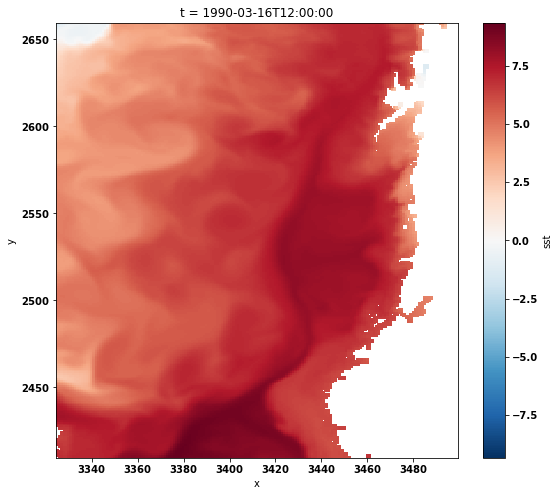

In [8]:
ds.sst.isel(t = 2).plot(figsize = (9,8))

To access a range of values in a dimension, you can specify a range to use:

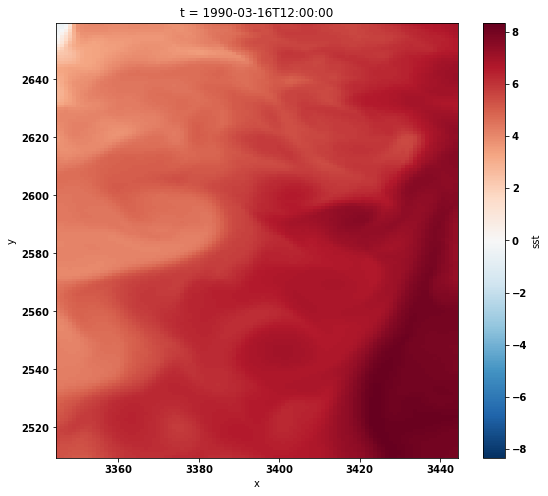

In [9]:
ds.sst.isel(t = 2, y = range(100,250), x = range(20,120)).plot(figsize = (9,8))

We can also look at the explicit time index using use the ```.sel()``` method.  To speify a range of datetimes, we need to use the ```slice``` function to index over multiple times rather than the ```range()``` function as the ```range()``` function only accepts integer arguments.

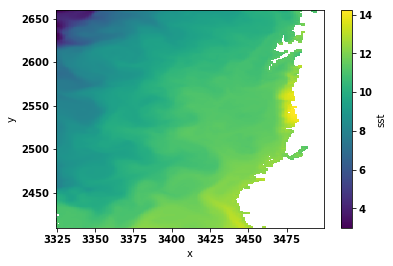

In [10]:
ds.sst.sel(t = slice('1990-6-1','1990-9-1')).mean(dim = 't').plot()

## Working with multiple files

With xarray you can read in multiple netcdf files using the ```.open_mfdataset()``` method.

You can specify the input files as list or by using the wildcard operator * for strings to find all the file names matching a certain pattern.

In [11]:
ds = xr.open_mfdataset('nordic_seas_*')
ds

<xarray.Dataset>
Dimensions:  (t: 24, x: 175, y: 250)
Coordinates:
    lon      (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 -6.254 ...
    lat      (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y        (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x        (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t        (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst      (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(12, 250, 175)>
    sss      (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(12, 250, 175)>
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:                   39
    conventions:          CF-1.1
    production:           An IPSL model

The length of the time dimension is now 24 as xarray has opened the files for 1990 and 1991 and concatenated them along the time axis.

## Dask in xarray

If you're working with multiple files the size of the data will rapidly become bigger than your memory. In this case you can take advantage of the integration of dask into xarray.

In fact, if we inspect the dataset object ```ds```, we can see that when you use ```.open_mfdataset()``` then dask is automatically invoked.  

We can see this as the data variables ```sst``` and ```sss``` above are shown to be dask.array objects.

We can also see what the chunks are using the ```ds.chunks``` attribute.

In [12]:
ds.chunks

Frozen(SortedKeysDict({'t': (12, 12), 'y': (250,), 'x': (175,)}))

In this case the datset is broken up into two chunks, each with 12 months.  This shows that the automatic chunking approach is to chunk the files into segments that correspond to the individual netcdf files.

You can specify a different chunking approach by passing an explicit chunking scheme when you open the files.  For example, we could say that we want the chunks to correspond to 6-month periods.

In [13]:
ds = xr.open_mfdataset('nordic_seas_*', chunks={'t':6 ,'y':250,'x':175})
ds.chunks

Frozen(SortedKeysDict({'t': (6, 6, 6, 6), 'y': (250,), 'x': (175,)}))

As with using dask on its own, operations on the dataset are now **lazy**.  For example, we can add a new time-mean variable to the dataset.

In [14]:
ds['sst_mean'] = ds.sst.mean(dim = 't')
ds

<xarray.Dataset>
Dimensions:   (t: 24, x: 175, y: 250)
Coordinates:
    lon       (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 ...
    lat       (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y         (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x         (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t         (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst       (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sss       (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sst_mean  (y, x) float64 dask.array<shape=(250, 175), chunksize=(250, 175)>
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:               

In this case the data variable ```sst_mean``` has been added to the dataset ```ds```.   However, the data in the ```sst``` and ```sss``` variables has not yet been read from the netcdf file on the disk and the values in ```sst_mean``` have not yet been calculated.  Instead, a task-graph has been created that sets out how ```sst_mean``` would be created.

To trigger the evaulation of ```sst_mean```, you use the ```.load()``` method rather than the ```.compute()``` method used with dask alone.  This change in syntax from ```.compute()``` to ```.load()``` reflects the fact the triggering evaluation in xarray often leads to data being loaded from the hard disk into memory.

In [15]:
ds.sst_mean.load();
ds

/home/lbran/anaconda2/envs/base3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:   (t: 24, x: 175, y: 250)
Coordinates:
    lon       (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 ...
    lat       (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y         (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x         (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t         (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst       (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sss       (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sst_mean  (y, x) float64 nan 9.12 9.111 9.096 9.118 9.165 9.193 9.218 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:                 

We now see that the data variable ```sst_mean``` is no longer a ```dask.array``` object, but an in-memory array (it is not stated explicitly but the array is a standard numpy ```ndarray``` in memory).

If you are doing repeated calculations with the same data variable and have sufficient space in memory, it is better to have the data in memory as a numpy array rather than as a dask array.  You can load the data memory by using the same ```.load()``` method.

In [16]:
ds.sst.load()
ds

<xarray.Dataset>
Dimensions:   (t: 24, x: 175, y: 250)
Coordinates:
    lon       (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 ...
    lat       (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y         (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x         (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * t         (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
Data variables:
    sst       (t, y, x) float64 nan 7.726 7.71 7.684 7.729 7.848 7.982 8.148 ...
    sss       (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sst_mean  (y, x) float64 nan 9.12 9.111 9.096 9.118 9.165 9.193 9.218 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA0083-N06_1m_19700101_19700331
    DOMAIN_size_global:   [4322 3059]
    timeStamp:            2014-Dec-21 06:34:28 GMT
    NCO:                  "4.5.5"
    nj:                   39
    

# Groupby in xarray

Xarray also has some powerful groupby methods.  For example, we can create a new array with the seasonal cycle for SST and SSS:

In [17]:
season_cycle = ds.groupby('t.month').mean(dim = 't')
season_cycle

<xarray.Dataset>
Dimensions:   (month: 12, x: 175, y: 250)
Coordinates:
    lon       (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 -6.352 ...
    lat       (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 61.53 61.52 ...
  * y         (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 ...
  * x         (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 ...
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst       (month, y, x) float64 nan 7.575 7.559 7.495 7.504 7.622 7.734 ...
    sss       (month, y, x) float64 dask.array<shape=(12, 250, 175), chunksize=(1, 250, 175)>
    sst_mean  (month, y, x) float64 nan 9.12 9.111 9.096 9.118 9.165 9.193 ...

This groupby operation has created a dataset with a new month coordinate i.e. the average for each month at each grid point.  We can plot the mean SST and SSS seasonal cycle over this two-year period.

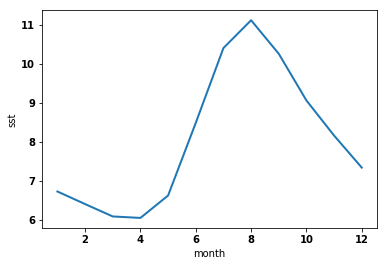

In [18]:
season_cycle.sst.mean(dim = ['x','y']).plot();

## Exercise
Plot the seasonal cycle of SSS

Even better, we can now create a new variable in ```ds``` that has the seasonal cycle removed.

We do this by using ```.groupby``` on ```ds.sst``` to partition the dataset into months and then subtracting the seasonal cycle

In [19]:
ds['sst_deseasonalised'] = ds.sst.groupby('t.month') - season_cycle.sst
ds

<xarray.Dataset>
Dimensions:             (t: 24, x: 175, y: 250)
Coordinates:
    lon                 (y, x) float64 -6.838 -6.741 -6.644 -6.546 -6.449 ...
    lat                 (y, x) float64 61.58 61.57 61.56 61.55 61.54 61.54 ...
  * y                   (y) int32 2410 2411 2412 2413 2414 2415 2416 2417 ...
  * x                   (x) int32 3325 3326 3327 3328 3329 3330 3331 3332 ...
  * t                   (t) datetime64[ns] 1990-01-16T12:00:00 1990-02-15 ...
    month               (t) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 ...
Data variables:
    sst                 (t, y, x) float64 nan 7.726 7.71 7.684 7.729 7.848 ...
    sss                 (t, y, x) float64 dask.array<shape=(24, 250, 175), chunksize=(6, 250, 175)>
    sst_mean            (y, x) float64 nan 9.12 9.111 9.096 9.118 9.165 ...
    sst_deseasonalised  (t, y, x) float64 nan 0.1513 0.1516 0.1888 0.2249 ...
Attributes:
    ni:                   4322
    ibegin:               1
    name:                 ORCA

## Exercise
You want to understand where the highest non-seasonal variability in surface salinity is found.  Plot the standard deviation in time of the sea surface salt field.

## Multidimensional groupby

Although we can't index using the lat-lon coordinates, we [can use groupby with them](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html) using the ```.groupby_bins``` method.

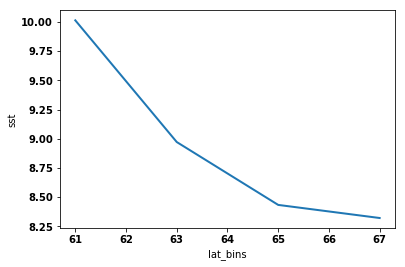

In [20]:
## Specify that we want to bin our data in 2-degree latitude bins
lat_bins = np.arange(60,70,2)
# Give labels for the center of each bin
lat_center = np.arange(61,69,2)
# Groupby into the latitude bins
ds.sst.groupby_bins('lat', lat_bins, labels = lat_center).mean().plot()

## Exercise
Set appropriate longitude bins for this dataset and get the mean values for SST with longitude.  What does this longitude-mean pattern indicate about the mean meridional direction of the ocean currents at the surface?

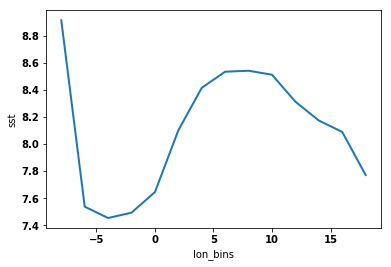

In [21]:
## Specify that we want to bin our data in 2-degree latitude bins
lon_bins = np.arange(-8,30,2)
# Give labels for the center of each bin
lon_center = np.arange(-8,28,2)
# Groupby into the latitude bins
ds.sst.groupby_bins('lon', lon_bins, labels = lon_center).mean().plot();

## Next steps
Switching to a labelled data approach takes a bit of practice at the start, but then becomes more intuitive.  The important part is just to load up some of your own data and incorporate xarray in your own workflow.

xarray is a [welcoming open source project](https://github.com/pydata/xarray).  If you find a bug or think of a new feature that could be added, get involved.

If you want to focus more on developing effective tools for analysing climate model output, [you can get involved in pangeo](https://pangeo-data.github.io/people/).